In [55]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import matplotlib.pyplot as plt
from source.datasets import CatBallDataset, AnalogBits, custom_collate_with_info
import numpy as np
import jlc
import torch


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [14]:
%load_ext autoreload
%autoreload 2
import sys, os
sys.path.append('./source/')
from source.utils import write_args, model_and_diffusion_defaults, SmartParser
from argparse import Namespace
args = SmartParser().get_args(do_parse_args=False)
print(args)
#write_args(args, "./saves/test/args.json")
args.ema_rate

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Namespace(attention_resolutions='-2,-1', bce_loss=False, betas='0.9,0.999', cat_ball_data=False, clip_denoised=True, conditioning_type='none', datasets='non-medical', datasets_as_classes=False, deeper_net=True, dropout=0.0, ema_rate='0.9999', eval_batch_size=0, eval_ema_step=50000, eval_guidance_weight=0.0, eval_interval=5000, eval_num_steps=100, fp16_scale_growth=0.001, gamma_clip_min=1e-09, image_size=32, input_scale=1.0, log_train_metrics='loss', log_vali_interval=200, logs_folder='../logs2/', loss_weights='uniform', lr=0.0001, lr_decay_steps=0, lr_decay_type='linear', lr_warmup_steps=0, lr_warmup_type='linear', major_vote_number=5, max_iter=100000, max_num_classes=8, min_label_size=0.01, model_name='test', model_str='model*', no_diffusion=False, no_image_prob=0.1, no_label_prob=0.1, noise_schedule='linear', num_channels=64, num_classes=0, num_heads=4, num_heads_upsample=-1, num_res_blocks=3, num

'0.9999'

In [10]:
%matplotlib inline

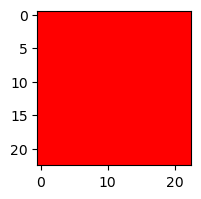

In [55]:
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
from PIL import Image
from tempfile import NamedTemporaryFile
import cv2
import warnings

def render_axis_ticks(image_width=1000,
                      num_uniform_spaced=None,
                      bg_color="white",
                      xtick_kwargs={"labels": np.arange(5)},
                      tick_params={}):
    old_backend = matplotlib.rcParams['backend']
    old_dpi = matplotlib.rcParams['figure.dpi']
    dpi = 100
    if num_uniform_spaced is None:
        num_uniform_spaced = len(xtick_kwargs["labels"])
    n = num_uniform_spaced
     
    matplotlib.rcParams['figure.dpi'] = dpi
    matplotlib.use('Agg')
    try:        
        fig = plt.figure(figsize=(image_width/dpi, 1e-15), facecolor=bg_color)
        ax = plt.Axes(fig, [0., 0., 1., 1.])
        ax.set_facecolor(bg_color)
        ax.set_frame_on(False)
        ax.tick_params(**tick_params)
        fig.add_axes(ax)
        
        plt.yticks([])
        plt.xlim(0, n)
        x_pos = np.linspace(0.5,n-0.5,n)
        if not "ticks" in xtick_kwargs:
            xtick_kwargs["ticks"] = x_pos[:len(xtick_kwargs["labels"])]
        else:
            if xtick_kwargs["ticks"] is None:
                xtick_kwargs["ticks"] = x_pos[:len(xtick_kwargs["labels"])]
        plt.xticks(**xtick_kwargs)
        
        
        warnings.filterwarnings("ignore") #avoid warning about agg backend not showing anything
        fig.show()
        warnings.resetwarnings()

        with NamedTemporaryFile(suffix=".png", delete=False) as temp_file:
            temp_filename = temp_file.name
            fig.savefig(temp_filename, format='png', bbox_inches='tight', pad_inches=0)
        im = np.array(Image.open(temp_filename))
        if not im.shape[1]==image_width:
            #reshape with cv2 linear interpolation
            warnings.warn("Image width is not as expected, likely due to too large text labels. Reshaping with cv2 linear interpolation.")
            im = cv2.resize(im, (image_width, im.shape[0]), interpolation=cv2.INTER_LINEAR)

        matplotlib.use(old_backend)
        matplotlib.rcParams['figure.dpi'] = old_dpi
    except:
        matplotlib.use(old_backend)
        matplotlib.rcParams['figure.dpi'] = old_dpi
        raise
    return im

#test for empty image without ticks
im = render_axis_ticks(23,bg_color="red",xtick_kwargs={"labels": ["  "]}, tick_params={"bottom": False})
plt.figure(figsize=(20,2))
plt.imshow(im)

In [8]:


im = render_axis_ticks(bg_color="white",xtick_kwargs={"labels":["1","tgwo","three","four","five"], "fontsize":20})
print(im.shape)
plt.figure(figsize=(15,2))
plt.imshow(im)

(37, 1000, 4)


In [3]:
import mmcv
import numpy as np


def intersect_and_union(pred_label,
                        label,
                        num_classes,
                        ignore_index,
                        label_map=dict(),
                        reduce_zero_label=False):

    if isinstance(pred_label, str):
        pred_label = np.load(pred_label)

    if isinstance(label, str):
        label = mmcv.imread(label, flag='unchanged', backend='pillow')
    # modify if custom classes
    if label_map is not None:
        for old_id, new_id in label_map.items():
            label[label == old_id] = new_id
    if reduce_zero_label:
        # avoid using underflow conversion
        label[label == 0] = 255
        label = label - 1
        label[label == 254] = 255

    mask = (label != ignore_index)
    pred_label = pred_label[mask]
    label = label[mask]

    intersect = pred_label[pred_label == label]
    area_intersect, _ = np.histogram(
        intersect, bins=np.arange(num_classes + 1))
    area_pred_label, _ = np.histogram(
        pred_label, bins=np.arange(num_classes + 1))
    area_label, _ = np.histogram(label, bins=np.arange(num_classes + 1))
    area_union = area_pred_label + area_label - area_intersect

    return area_intersect, area_union, area_pred_label, area_label


def total_intersect_and_union(results,
                              gt_seg_maps,
                              num_classes,
                              ignore_index,
                              label_map=dict(),
                              reduce_zero_label=False):

    num_imgs = len(results)
    assert len(gt_seg_maps) == num_imgs
    total_area_intersect = np.zeros((num_classes, ), dtype=np.float)
    total_area_union = np.zeros((num_classes, ), dtype=np.float)
    total_area_pred_label = np.zeros((num_classes, ), dtype=np.float)
    total_area_label = np.zeros((num_classes, ), dtype=np.float)
    for i in range(num_imgs):
        area_intersect, area_union, area_pred_label, area_label = \
            intersect_and_union(results[i], gt_seg_maps[i], num_classes,
                                ignore_index, label_map, reduce_zero_label)
        total_area_intersect += area_intersect
        total_area_union += area_union
        total_area_pred_label += area_pred_label
        total_area_label += area_label
    return total_area_intersect, total_area_union, \
        total_area_pred_label, total_area_label


def mean_iou(results,
             gt_seg_maps,
             num_classes,
             ignore_index,
             nan_to_num=None,
             label_map=dict(),
             reduce_zero_label=False):
    all_acc, acc, iou = eval_metrics(
        results=results,
        gt_seg_maps=gt_seg_maps,
        num_classes=num_classes,
        ignore_index=ignore_index,
        metrics=['mIoU'],
        nan_to_num=nan_to_num,
        label_map=label_map,
        reduce_zero_label=reduce_zero_label)
    return all_acc, acc, iou


def mean_dice(results,
              gt_seg_maps,
              num_classes,
              ignore_index,
              nan_to_num=None,
              label_map=dict(),
              reduce_zero_label=False):
    all_acc, acc, dice = eval_metrics(
        results=results,
        gt_seg_maps=gt_seg_maps,
        num_classes=num_classes,
        ignore_index=ignore_index,
        metrics=['mDice'],
        nan_to_num=nan_to_num,
        label_map=label_map,
        reduce_zero_label=reduce_zero_label)
    return all_acc, acc, dice


def eval_metrics(results,
                 gt_seg_maps,
                 num_classes,
                 ignore_index,
                 metrics=['mIoU'],
                 nan_to_num=None,
                 label_map=dict(),
                 reduce_zero_label=False):

    if isinstance(metrics, str):
        metrics = [metrics]
    allowed_metrics = ['mIoU', 'mDice']
    if not set(metrics).issubset(set(allowed_metrics)):
        raise KeyError('metrics {} is not supported'.format(metrics))
    total_area_intersect, total_area_union, total_area_pred_label, \
        total_area_label = total_intersect_and_union(results, gt_seg_maps,
                                                     num_classes, ignore_index,
                                                     label_map,
                                                     reduce_zero_label)
    all_acc = total_area_intersect.sum() / total_area_label.sum()
    acc = total_area_intersect / total_area_label
    ret_metrics = [all_acc, acc]
    for metric in metrics:
        if metric == 'mIoU':
            iou = total_area_intersect / total_area_union
            ret_metrics.append(iou)
        elif metric == 'mDice':
            dice = 2 * total_area_intersect / (
                total_area_pred_label + total_area_label)
            ret_metrics.append(dice)
    if nan_to_num is not None:
        ret_metrics = [
            np.nan_to_num(metric, nan=nan_to_num) for metric in ret_metrics
        ]
    return ret_metrics

In [20]:
import numpy as np

def mean_iou(pred, target, num_classes=None, ignore_index=0):
    if num_classes is None:
        num_classes = max(np.max(pred), np.max(target)) + 1
    intersect = pred[pred == target]
    area_intersect, _ = np.histogram(intersect, bins=np.arange(num_classes + 1))
    area_pred_label, _ = np.histogram(pred, bins=np.arange(num_classes + 1))
    area_label, _ = np.histogram(target, bins=np.arange(num_classes + 1))
    area_union = area_pred_label + area_label - area_intersect

    iou = area_intersect[area_union!=0]/area_union[area_union!=0]
    iou = np.mean(iou)
    return iou

pred  = np.array([0,0,0,0,0,   0,1,1,1,2,  2,2,2,3])
target = np.array([1,1,1,1,1,   1,1,1,1,1,  1,1,1,1])
mean_iou(target,pred, 4)

0.05357142857142857

In [46]:
from sklearn.metrics import confusion_matrix
import numpy as np
from scipy.optimize import linear_sum_assignment

pred   = np.array([0,0,0,0,0,   2,2,2,2,2,  3,3,5,4])
target = np.array([1,1,1,1,1,   3,3,3,3,3,  2,2,2,2])



hungarian_iou(target,pred)

[[1.   0.   0.   0.   0.  ]
 [0.   0.   0.5  0.25 0.25]
 [0.   1.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.  ]]
(array([0, 1, 2, 3, 4]), array([0, 2, 1, 3, 4]))


(0.8333333333333334,)

In [45]:
(2.75/3)

0.9166666666666666

In [2]:
percentage = 42.345
formatted_percentage = f'{percentage:0.1f}'

print(formatted_percentage)


42.3


In [2]:
import sys, os

sys.path.append('./source/')        
from utils import SmartParser
from training import DiffusionModelTrainer
from training import DiffusionModelTrainer
from sampling import DiffusionSampler

args = SmartParser().get_args(do_parse_args=False)
args.model_name = "2024-01-12-17-41-40-226108_default"
args.save_path = "./saves/"+args.model_name
trainer = DiffusionModelTrainer(args)
sampler = DiffusionSampler(diffusion=trainer.cgd,
                        model=trainer.model,
                        dataloader=trainer.vali_dl,
                        step=trainer.step,
                        do_agg=False,
                        trainer=trainer)
sampler.opts.num_samples = 2
sampler.opts.num_votes = 5
sampler.opts.num_inter_samples = 2
sampler.opts.num_inter_steps = 20
sampler.opts.save_plot_inter_path = os.path.join(args.save_path,"inter")
sampler.opts.save_concat_plot_inter_path = os.path.join(args.save_path,"inter_concat.png")
output = sampler.sample(num_timesteps=100)

processing dataset:  coco
processing dataset:  pascal
processing dataset:  sa1b
processing dataset:  coift
processing dataset:  hrsod
processing dataset:  to5k
processing dataset:  dram
processing dataset:  cityscapes
processing dataset:  coco
processing dataset:  pascal
processing dataset:  sa1b
processing dataset:  coift
processing dataset:  hrsod
processing dataset:  to5k
processing dataset:  dram
processing dataset:  cityscapes
CUDA available. Using GPU.
Resuming training run.


Batch progress.: 100%|██████████| 1/1 [00:02<00:00,  2.57s/it]


In [36]:
root_ade20k_dir

'./data/ade20k/ADE20K_2016_07_26/images/training'

In [40]:
import os,glob
from pathlib import Path
import numpy as np
folder_path = "./data/ade20k"
root_ade20k_dir = os.path.join(folder_path,"ADE20K_2016_07_26","images")
paths = (list(Path(root_ade20k_dir).glob("*/*/*/*/*.jpg"))+
         list(Path(root_ade20k_dir).glob("*/*/*/*.jpg")))
filenames = [str(path) for path in paths]
print(len(paths))
print("\n".join(filenames[:10]))

20543
data/ade20k/ADE20K_2016_07_26/images/validation/c/circus_tent/outdoor/ADE_val_00001249.jpg
data/ade20k/ADE20K_2016_07_26/images/validation/c/canal/natural/ADE_val_00000222.jpg
data/ade20k/ADE20K_2016_07_26/images/validation/c/canal/urban/ADE_val_00001222.jpg
data/ade20k/ADE20K_2016_07_26/images/validation/c/convenience_store/outdoor/ADE_val_00000278.jpg
data/ade20k/ADE20K_2016_07_26/images/validation/c/convenience_store/indoor/ADE_val_00001277.jpg
data/ade20k/ADE20K_2016_07_26/images/validation/c/cabin/outdoor/ADE_val_00001218.jpg
data/ade20k/ADE20K_2016_07_26/images/validation/c/cabin/outdoor/ADE_val_00000219.jpg
data/ade20k/ADE20K_2016_07_26/images/validation/c/cavern/outdoor/ADE_val_00000238.jpg
data/ade20k/ADE20K_2016_07_26/images/validation/c/cavern/indoor/ADE_val_00001237.jpg
data/ade20k/ADE20K_2016_07_26/images/validation/c/church/outdoor/ADE_val_00001248.jpg


In [51]:
from PIL import Image
def load_image_label_info(file_name):
    image_path = file_name
    label_path = image_path.replace(".jpg","_seg.png")
    json_path = image_path.replace(".jpg","_atr.txt")
    info = np.loadtxt(json_path, dtype=str, delimiter="#", comments=None)
    print(Path(file_name).parts[4])
    image = Image.open(image_path)
    label = Image.open(label_path)

    #info = {"classes": [0],
    #        "split_idx": ["training","validation"].index(Path(file_name).parts[4])}
    return image,label,info

image,label,info = load_image_label_info(filenames[0])
image,label = np.array(image),np.array(label)
print(image.shape,label.shape,info)

validation
(960, 1280, 3) (960, 1280, 3) [['001 ' ' 0 ' ' 0 ' ' sky ' ' sky ' ' ""']
 ['002 ' ' 0 ' ' 0 ' ' road, route ' ' road ' ' ""']
 ['003 ' ' 0 ' ' 0 ' ' road, route ' ' road ' ' ""']
 ['004 ' ' 0 ' ' 0 ' ' wall ' ' wall ' ' ""']
 ['005 ' ' 0 ' ' 0 ' ' wall ' ' wall ' ' ""']
 ['006 ' ' 0 ' ' 0 ' ' building, edifice ' ' building ' ' ""']
 ['007 ' ' 0 ' ' 0 ' ' tree ' ' trees ' ' ""']
 ['008 ' ' 0 ' ' 0 ' ' earth, ground ' ' ground ' ' ""']
 ['009 ' ' 0 ' ' 0 ' ' big top ' ' big top ' ' ""']
 ['010 ' ' 0 ' ' 0 ' ' tree ' ' tree ' ' ""']
 ['011 ' ' 0 ' ' 0 ' ' tree ' ' trees ' ' ""']
 ['012 ' ' 0 ' ' 0 ' ' tree ' ' trees ' ' ""']
 ['013 ' ' 0 ' ' 0 ' ' earth, ground ' ' ground ' ' ""']
 ['014 ' ' 0 ' ' 0 ' ' grass ' ' grass ' ' ""']
 ['015 ' ' 0 ' ' 0 ' ' pole ' ' pole ' ' ""']
 ['016 ' ' 0 ' ' 0 ' ' pole ' ' pole ' ' ""']
 ['017 ' ' 0 ' ' 0 ' ' pole ' ' pole ' ' ""']
 ['018 ' ' 0 ' ' 0 ' ' spotlight, spot ' ' spotlight ' ' ""']]


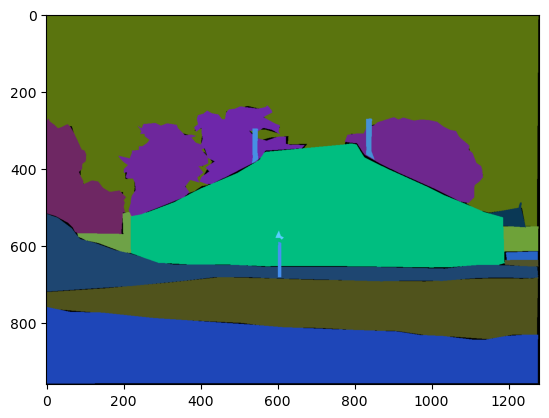

In [49]:
import matplotlib.pyplot as plt
plt.imshow(label)

In [50]:
label[0,0]

array([ 90, 116,  14], dtype=uint8)

In [31]:

str_list = [p.parent.parent.name for p in paths]
print(np.unique(str_list, return_counts=True))

(array(['cabin', 'canal', 'car_interior', 'cargo_deck', 'carport',
       'casino', 'cathedral', 'cavern', 'chicken_coop', 'chicken_farm',
       'choir_loft', 'church', 'circus_tent', 'cloakroom', 'clock_tower',
       'cloister', 'control_tower', 'convenience_store', 'covered_bridge',
       'cubicle'], dtype='<U17'), array([18, 21, 20,  6, 26, 60, 35, 19, 22, 13, 11, 38, 12, 10,  4, 29, 29,
       20, 21, 30]))


In [15]:
file_name_list[:10]

['./data/ade20k/ADE20K_2016_07_26/images/training/c/circus_tent/outdoor/ADE_train_00005589_seg.png',
 './data/ade20k/ADE20K_2016_07_26/images/training/c/circus_tent/outdoor/ADE_train_00005584_seg.png',
 './data/ade20k/ADE20K_2016_07_26/images/training/c/circus_tent/outdoor/ADE_train_00005592_parts_1.png',
 './data/ade20k/ADE20K_2016_07_26/images/training/c/circus_tent/outdoor/ADE_train_00005585_seg.png',
 './data/ade20k/ADE20K_2016_07_26/images/training/c/circus_tent/outdoor/ADE_train_00005591_seg.png',
 './data/ade20k/ADE20K_2016_07_26/images/training/c/circus_tent/outdoor/ADE_train_00005590_seg.png',
 './data/ade20k/ADE20K_2016_07_26/images/training/c/circus_tent/outdoor/ADE_train_00005586_seg.png',
 './data/ade20k/ADE20K_2016_07_26/images/training/c/circus_tent/outdoor/ADE_train_00005592_seg.png',
 './data/ade20k/ADE20K_2016_07_26/images/training/c/circus_tent/outdoor/ADE_train_00005588_seg.png',
 './data/ade20k/ADE20K_2016_07_26/images/training/c/circus_tent/outdoor/ADE_train_00005

In [6]:
os.path.isdir(root_ade20k_dir)

False

In [54]:
import numpy as np

random_ints = np.random.randint(100,size=100)
print(np.bincount(random_ints))
print(len(np.bincount(random_ints)))
print(sum(np.bincount(random_ints)))

[2 2 0 0 2 3 1 4 0 1 1 0 0 1 1 1 2 0 1 1 0 1 0 0 0 2 0 0 1 1 1 1 0 0 1 2 0
 3 1 2 1 1 0 0 0 1 0 2 2 1 1 1 4 1 0 1 1 1 1 2 0 0 0 2 1 3 0 0 3 1 2 2 0 3
 1 0 0 0 0 0 1 0 0 0 0 0 1 1 0 3 3 2 3 0 2 1 2 0 0 3]
100
100


In [56]:
a = np.array([1,0,5,2,3])
print(np.argsort(a))
print(np.argsort(np.argsort(a)))

[1 0 3 4 2]
[1 0 4 2 3]


In [ ]:
python train.py --model_name small[points_test]
python train.py --model_name small[1]
python train.py --model_name small[2]
python train.py --model_name small[3]
python train.py --model_name small[4]
python train.py --model_name small[5]
python train.py --model_name small[6]
python train.py --model_name small[7]
f

In [110]:
import torch
import numpy as np



label = torch.zeros((10,10),dtype=torch.int64)
label[0,0:3] = 1
label[1,0:5] = 2
print(label)
print(points_image_from_label(label))

tensor([[1, 1, 1, 0, 0, 0, 0, 0, 0, 0],
        [2, 2, 2, 2, 2, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])


In [230]:
import jlc
#jlc.functions.load_state_dict_loose
help(jlc)

AttributeError: module 'jlc.functions' has no attribute 'load_state_dict_loose'

In [228]:
from sklearn.metrics import confusion_matrix
import numpy as np
from scipy.optimize import linear_sum_assignment

def extend_shorter_vector(vec1,vec2,fill_value=0):
    if len(vec1)<len(vec2):
        vec1 = np.concatenate([vec1,(fill_value*np.ones(len(vec2)-len(vec1))).astype(vec1.dtype)])
    elif len(vec2)<len(vec1):
        vec2 = np.concatenate([vec2,(fill_value*np.ones(len(vec1)-len(vec2))).astype(vec2.dtype)])
    return vec1,vec2

def hungarian_iou(target,pred,ignore_idx=0,return_assignment=False):
    if ignore_idx is None:
        ignore_idx = []
    if isinstance(ignore_idx,list):
        assert all([isinstance(idx,int) for idx in ignore_idx]), "ignore_idx must be None, int or list[int]"
    else:
        assert isinstance(ignore_idx,int), "ignore_idx must be None, int or list[int]"
        ignore_idx = [ignore_idx]
    
    uq_target,target,conf_rowsum = np.unique(target,return_counts=True,return_inverse=True)
    uq_pred,pred,conf_colsum = np.unique(pred,return_counts=True,return_inverse=True)
    conf_rowsum,conf_colsum = extend_shorter_vector(conf_rowsum,conf_colsum)
    uq_target,uq_pred = extend_shorter_vector(uq_target,uq_pred,fill_value=-1)
    
    conf_rowsum,conf_colsum = conf_rowsum[:,None],conf_colsum[None,:]
    intersection = confusion_matrix(target, pred)
    print(conf_colsum)
    print(conf_rowsum)
    union = conf_rowsum + conf_colsum - intersection
    iou_hungarian_mat = intersection / union

    print(iou_hungarian_mat)
    print(uq_target,uq_pred)
    print(intersection,union)
    mask_pred = np.isin(uq_pred,ignore_idx)
    mask_target = np.isin(uq_target,ignore_idx)
    #handle edge cases
    if all(mask_pred) and all(mask_target):
        val = 1.0
        assign_pred = np.array([],dtype=int)
        assign_target = np.array([],dtype=int)
        iou_per_assignment = np.array([],dtype=float)
    elif all(mask_pred) or all(mask_target):
        val = 0.0
        assign_pred = np.array([],dtype=int)
        assign_target = np.array([],dtype=int)
        iou_per_assignment = np.array([],dtype=float)
    else:
        #force optimal assignment to match ignore_idx with ignore_idx
        iou_hungarian_mat[mask_target,:] = 0
        iou_hungarian_mat[:,mask_pred] = 0
        iou_hungarian_mat += mask_target[:,None]*mask_pred[None,:]

        assignment = linear_sum_assignment(iou_hungarian_mat, maximize=True)

        assign_target = uq_target[assignment[0]]
        assign_pred = uq_pred[assignment[1]]
        iou_per_assignment = iou_hungarian_mat[assignment[0],assignment[1]]
        
        #remove matches which have ignore_idx or dummy (-1) as both target and pred
        ignore_idx.append(-1)
        mask = np.logical_or(~np.isin(assign_pred,ignore_idx),~np.isin(assign_target,ignore_idx))
        assign_target,assign_pred,iou_per_assignment = assign_target[mask],assign_pred[mask], iou_per_assignment[mask]
        
        val = np.mean(iou_per_assignment)

    if return_assignment:
        return val, assign_target, assign_pred, iou_per_assignment
    else:
        return val

pred =   np.array([0,0,0,4,4])
target = np.array([1,0,0,4,4])

print(hungarian_iou(target,pred,ignore_idx=[0],return_assignment=True))

[[3 2 0]]
[[2]
 [1]
 [2]]
[[0.66666667 0.         0.        ]
 [0.33333333 0.         0.        ]
 [0.         1.         0.        ]]
[0 1 4] [ 0  4 -1]
[[2 0 0]
 [1 0 0]
 [0 2 0]] [[3 4 2]
 [3 3 1]
 [5 2 2]]
(0.5, array([1, 4]), array([-1,  4]), array([0., 1.]))


In [240]:
from pathlib import Path

save_path = Path("./saves")
print(list(save_path.glob("2024-01-12-17-41-40-226108_default/ckpt_100000.pt")))

[PosixPath('saves/2024-01-12-17-41-40-226108_default/ckpt_100000.pt')]


In [ ]:
python train.py --model_name weak30k
python train.py --model_name weak30k[1]
python train.py --model_name weak30k[2]
python train.py --model_name weak30k[3]
python train.py --model_name weak30k[4]
python train.py --model_name weak30k[5]
python train.py --model_name weak30k[6]
python train.py --model_name weak30k[7]
f

In [5]:
import sys,os 
sys.path.append('./source/')
from utils import SmartParser
SmartParser().get_args(alt_parse_args=["--gen_setup","abc"])

Namespace(attention_resolutions='-2,-1', bce_loss=False, betas='0.9,0.999', cat_ball_data=False, ckpt_name='', class_type='none', clip_grad_norm=1.0, cond_prob=0.25, cond_type='none', datasets='non-medical', deeper_net=False, dropout=0.0, ema_rate='0.9999', fp16_scale_growth=0.001, gamma_clip_max=1e-09, gamma_clip_min=1e-09, gen_interval=1000, gen_setups='abc', image_prob=0.9, image_size=64, input_scale=0.01, log_train_metrics='loss,grad_norm', log_vali_interval=200, loss_weights='SNR', lr=0.0001, lr_decay_steps=0, lr_decay_type='cosine', lr_warmup_steps=0, lr_warmup_type='linear', max_iter=100000, max_num_classes=8, min_label_size=0.0, mode='new', model_name='default', no_diffusion=False, noise_schedule='cosine', num_channels=64, num_heads=4, num_heads_upsample=-1, num_res_blocks=3, num_vali_batches=8, predict='x', remove_old_plots=True, resume_from_step=False, run_without_test=False, save_best_ckpt=False, save_ckpt_steps='-1', save_interval=5000, save_path='', schedule_sampler='unifo

In [5]:
str_to_check = "0.1243249551390409"
#check if the string is a float
print(str_to_check)

True


In [11]:

from sklearn.metrics import adjusted_rand_score as ari
import numpy as np
pred = np.array([0,0,0,0,-1,   0,0,0,0,0  ,0,0,0,0])
target = np.arange(14)+1
ari(target,pred)

0.0

In [12]:
tn, fp, fn, tp = 0, 0, 3461155406, 833746354

2. * (tp * tn - fn * fp) / ((tp + fn) * (fn + tn) +
                                       (tp + fp) * (fp + tn))

0.0

In [28]:
strings = [
            "model_name # ari      hiou     iou      max_ari  max_hiou  mi       step   gen_id    setup_name     save_path                              ",
            "###########################################################################################################################################",
            "weak30k    # 0.19654, 0.14555, 0.04918, 0.35134, 0.21887 , 0.25257, 30000, many_ema, ema_vali-ts10, 2024-01-19-15-30-36-544073_weak30k   , ",
            "weak30k[1] # 0.00251, 0.05383, 0.04121, 0.00495, 0.05776 , 0.00655, 30000, many_ema, ema_vali-ts10, 2024-01-19-20-11-16-488430_weak30k[1], ",
            "weak30k[2] # 0.01090, 0.06365, 0.04108, 0.01898, 0.07020 , 0.02150, 30000, many_ema, ema_vali-ts10, 2024-01-20-00-49-57-752052_weak30k[2], ",
            "weak30k[3] # 0.16458, 0.14400, 0.04788, 0.32155, 0.23593 , 0.22795, 30000, many_ema, ema_vali-ts10, 2024-01-20-05-29-37-392338_weak30k[3], ",
            "weak30k[4] # 0.20316, 0.14806, 0.03875, 0.31831, 0.19280 , 0.23632, 30000, many_ema, ema_vali-ts10, 2024-01-20-10-07-28-392180_weak30k[4], ",
            "weak30k[5] # 0.17912, 0.13690, 0.05168, 0.34111, 0.22482 , 0.22245, 30000, many_ema, ema_vali-ts10, 2024-01-20-14-44-56-333466_weak30k[5], ",
            "weak30k[6] # 0.19276, 0.14022, 0.04967, 0.34772, 0.21564 , 0.24563, 30000, many_ema, ema_vali-ts10, 2024-01-20-19-22-16-692216_weak30k[6], ",
            "weak30k[7] # 0.17129, 0.13990, 0.05181, 0.30982, 0.21108 , 0.22967, 30000, many_ema, ema_vali-ts10, 2024-01-20-23-59-44-017522_weak30k[7], "
        ]

for s in strings:
    #s2 = s[40:47]
    s2 = s[13:20]
    if s==strings[2]:
        print(" "+s2)
    elif s==strings[-1]:
        print(s2+" ")
    else:
        print(s2)

ari    
#######
 0.19654
0.00251
0.01090
0.16458
0.20316
0.17912
0.19276
0.17129 


In [ ]:
#python sample.py --gen_id many --name_match_str "*30k;*30k[1];*30k[2];*30k[3];*30k[4];*30k[5];*30k[6];*30k[7]" --seed 0 --num_samples 100 --num_timesteps 10
#python sample.py --gen_id many_ema --name_match_str "*30k;*30k[1];*30k[2];*30k[3];*30k[4];*30k[5];*30k[6];*30k[7]" --seed 0 --num_samples 100 --num_timesteps 10 --ema_rate 0.9999

In [ ]:
 0.26122
0.03922
0.07792
0.30695
0.30986
0.30950
0.32359
0.24902


In [40]:
def div_val(tp,fn,fp,tn):
    return ((tp + fn) * (fn + tn) + (tp + fp) * (fp + tn))
def eks_val(tp,fn,fp,tn):
    return 2 * (tp * tn - fn * fp)
for i in range(16):
    #conver binary i to 4 bit
    binary =  np.binary_repr(i,width=4)
    #set tp,fn,fp,tn to the bits:
    tp,fn,fp,tn = [int(bit) for bit in binary]
    print("ratio "+str(div_val(tp,fn,fp,tn))+"/"+str(eks_val(tp,fn,fp,tn))+", params: "+str((tp,fn,fp,tn)))

ratio 0/0, params: (0, 0, 0, 0)
ratio 0/0, params: (0, 0, 0, 1)
ratio 1/0, params: (0, 0, 1, 0)
ratio 2/0, params: (0, 0, 1, 1)
ratio 1/0, params: (0, 1, 0, 0)
ratio 2/0, params: (0, 1, 0, 1)
ratio 2/-2, params: (0, 1, 1, 0)
ratio 4/-2, params: (0, 1, 1, 1)
ratio 0/0, params: (1, 0, 0, 0)
ratio 2/2, params: (1, 0, 0, 1)
ratio 2/0, params: (1, 0, 1, 0)
ratio 5/2, params: (1, 0, 1, 1)
ratio 2/0, params: (1, 1, 0, 0)
ratio 5/2, params: (1, 1, 0, 1)
ratio 4/-2, params: (1, 1, 1, 0)
ratio 8/0, params: (1, 1, 1, 1)


In [34]:
python train.py --model_name long[5b] --ckpt_name *long/ckpt_*.pt
python train.py --model_name long[6b] --ckpt_name *long/ckpt_*.pt
python train.py --model_name long[7b] --ckpt_name *long/ckpt_*.pt
python train.py --model_name long[8b] --ckpt_name *long/ckpt_*.pt
python train.py --model_name long[5] --ckpt_name *long/ckpt_*.pt
python train.py --model_name long[6] --ckpt_name *long/ckpt_*.pt
python train.py --model_name long[7] --ckpt_name *long/ckpt_*.pt
python train.py --model_name long[8] --ckpt_name *long/ckpt_*.pt
f

'0'

In [43]:
import sys, os

sys.path.append('./source/')        
from utils import SmartParser
from training import DiffusionModelTrainer

args = SmartParser().get_args(alt_parse_args=["--model_name","long"])
trainer = DiffusionModelTrainer(args)

Starting new training run.
CUDA available. Using GPU.
Number of trainable parameters: 155387142
Saving to: saves/2024-01-29-13-03-33-306594_long
processing dataset:  coco
processing dataset:  pascal
processing dataset:  sa1b
processing dataset:  coift
processing dataset:  hrsod
processing dataset:  to5k
processing dataset:  ade20k
processing dataset:  dram
processing dataset:  cityscapes
processing dataset:  coco
processing dataset:  pascal
processing dataset:  sa1b
processing dataset:  coift
processing dataset:  hrsod
processing dataset:  to5k
processing dataset:  ade20k
processing dataset:  dram
processing dataset:  cityscapes
Init complete.


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


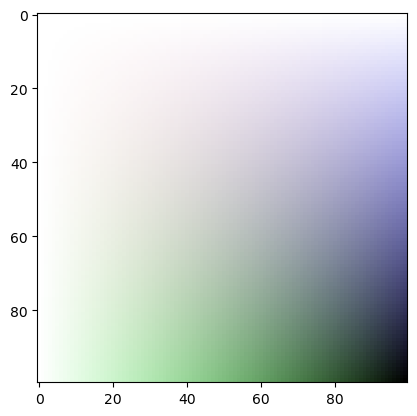

In [48]:
%load_ext autoreload
%autoreload 2
import os,sys
sys.path.append('./source/')
import numpy as np
import torch
import matplotlib.pyplot as plt
from source.plot_utils import analog_bits_on_image,mask_overlay_smooth
from source.datasets import AnalogBits

def analog_bits_on_image2(x_bits,im,ab):
    assert isinstance(x_bits,torch.Tensor), "analog_bits_on_image expects a torch.Tensor"
    x_bits_np = x_bits.cpu().numpy()
    mask = np.zeros((im.shape[0],im.shape[1],2**ab.num_bits))

    for i in range(2**ab.num_bits):
        pure = ab.int2bit(np.array([i]).reshape(1,1,1,1))
        mask[:,:,i] = np.exp((pure*x_bits_np*5).mean(1))
    mask = mask/np.sum(mask,axis=2,keepdims=True)
    return mask_overlay_smooth(im,mask,alpha_mask=1.0)

def analog_bits_on_image3(x_bits,im,ab):
    #sees bits as probs
    assert isinstance(x_bits,torch.Tensor), "analog_bits_on_image expects a torch.Tensor"
    x_bits_np = x_bits.cpu().numpy()
    mask = np.zeros((im.shape[0],im.shape[1],2**ab.num_bits))

    for i in range(2**ab.num_bits):
        pure = ab.int2bit(np.array([i]).reshape(1,1,1,1))
        mask[:,:,i] = np.prod(1-0.5*np.abs(pure-x_bits_np)[0],axis=0)
    return mask_overlay_smooth(im,mask,alpha_mask=1.0)
    

num_bits = 2
ab = AnalogBits(num_bits=num_bits)

n = 100
X,Y = torch.meshgrid(torch.linspace(-1,1,n),torch.linspace(-1,1,n))
bits = torch.stack([X,Y],dim=0)
im = np.zeros((n,n,3))+0.5
plt.imshow(analog_bits_on_image3(bits,im,ab))


In [267]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import os,sys
sys.path.append('./source/')
sys.path.append('./data/')
import numpy as np
from data.download_datasets import process_bg, prettify_data
import matplotlib.pyplot as plt
from source.plot_utils import analog_bits_on_image,mask_overlay_smooth
import jlc
from PIL import Image
from pathlib import Path
from source.datasets import SegmentationDataset
import scipy.ndimage as nd
from source.nice_colors import largest_pallete
import tqdm
#dataset = SegmentationDataset()
#print(len(dataset))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


processing dataset:  sa1b


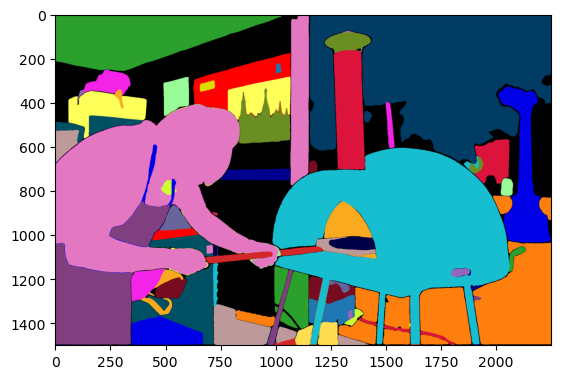

In [263]:
dataset = SegmentationDataset(datasets="sa1b")
i = 5
item = dataset[i][-1]

label_path = Path("./data/")/ item["dataset_name"] / item["label_path"]
image_path = Path("./data/")/ item["dataset_name"] / item["image_path"]
label = np.array(Image.open(label_path))
image = np.array(Image.open(image_path))
plt.imshow(mask_overlay_smooth(image,mask=label.astype(np.uint8),alpha_mask=1.0))

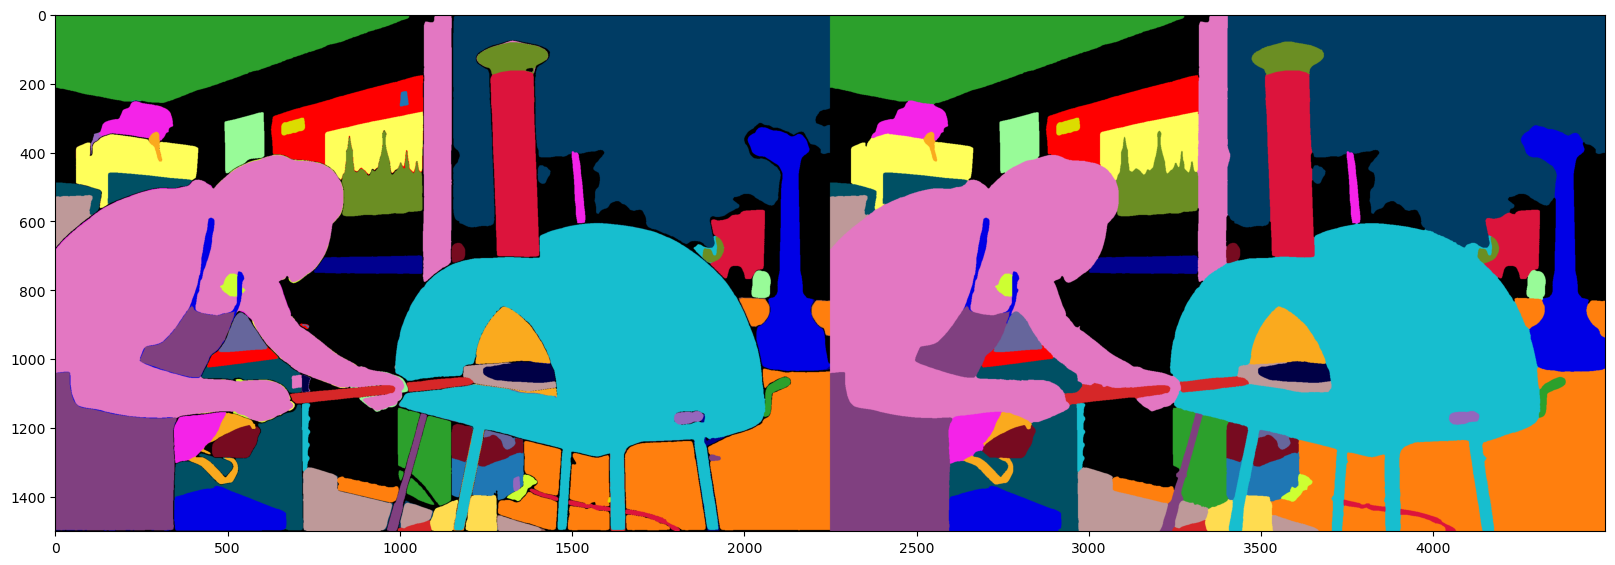

In [265]:

#mask is a 2d image


before = mask_overlay_smooth(image,label,alpha_mask=1.0)
after = mask_overlay_smooth(image,process_bg(label,conn_comp_r_balls_all=5),alpha_mask=1.0)
plt.figure(figsize=(20,10))
plt.imshow(np.concatenate([before,after],axis=1))
#plt.imshow(process_bg(label))
jlc.zoom()

In [269]:
for dataset in ["hrsod"]:#["to5k","dram","coift","cityscapes","pascal","sa1b","ade20k","coco"]:
    prop = prettify_data(SegmentationDataset(datasets=dataset,split="all",shuffle_datasets=False))
    print(f"Finished {dataset}. Saved images for {prop*100:.2f}% of the dataset")

processing dataset:  hrsod


  3%|▎         | 8/283 [00:02<01:20,  3.40it/s]


KeyboardInterrupt: 

In [ ]:
python train.py --model_name nc_big[128]
python train.py --model_name nc_big --mode cont
f

In [239]:
#dataset.datasets_info

dataset = SegmentationDataset(datasets="pascal")
n = 10
before = []
after = []
images = []
idx = np.random.randint(0,len(dataset),n)
for i in idx:
    info = dataset[i][-1]
    label_path = Path("./data/")/ info["dataset_name"] / info["label_path"]
    image_path = Path("./data/")/ info["dataset_name"] / info["image_path"]

    thin_bg = dataset.datasets_info[info["dataset_name"]]["thin_bg"]

    image = np.array(Image.open(image_path))
    label = np.array(Image.open(label_path))

    if thin_bg=="always":
        label_after = process_bg(label,always_override=True)
    elif thin_bg=="never":
        label_after = label
    elif thin_bg=="sometimes":
        label_after = process_bg(label)
    else:
        raise ValueError("thin_bg must be in ['always','never','sometimes']")
    images.append(image)
    before.append(mask_overlay_smooth(image,label,alpha_mask=1.0))
    after.append(mask_overlay_smooth(image,label_after,alpha_mask=1.0))


processing dataset:  pascal


In [ ]:
python train.py --model_name nc --mode cont --ckpt_name *298617_nc_*/ckpt_*.pt --predict v --loss_weights uniform
python train.py --model_name nc --predict "both;eps"
f

In [240]:
import cv2
%matplotlib qt
def concat_differently_shaped_images(list_of_rows,max_image_height=1000):
    image_heights = [im.shape[1] for im in sum(list_of_rows,[])]
    height_resize = min(max_image_height,max(image_heights))
    list_of_rows = [[cv2.resize(im, (int(im.shape[1]*height_resize/im.shape[0]),height_resize), interpolation=cv2.INTER_LINEAR) for im in row] for row in list_of_rows]
    return np.concatenate([np.concatenate(row1,axis=1) for row1 in list_of_rows],axis=0)

plt.figure(figsize=(24,8))
plt.imshow(concat_differently_shaped_images([images,before,after],max_image_height=200))
jlc.zoom()

In [280]:
max_ari = [
            "0.25752310755157043",
            "0.4027441485541241",
            "0.4369883904014509",
            "0.3865229550620852",
            "0.2617716941643542",
            "0.36919972915277655",
            "0.4214488572096229",
            "0.3389784510117421",
            "0.11617041820295584",
            "0.04536582538937587",
            "0.04580107806740408",
            "0.1754495810576414",
            "0.10670541203503942",
            "0.17708972662167127",
            "0.17309993459415934",
            "0.11415276269564202"
        ]
ari = ["0.17208297616183632",
            "0.28607540080045457",
            "0.31079156226727683",
            "0.2691516503453727",
            "0.14663709917240805",
            "0.24217298403602155",
            "0.2989037949036114",
            "0.23771766757453572",
            "0.05043377323908173",
            "0.025612010948157463",
            "0.024692920216225198",
            "0.08578848641162262",
            "0.048447976210734205",
            "0.09111691157063291",
            "0.08654262045272038",
            "0.05267552344614259"]

max_ari = [f"{float(x)*100:.1f}" for x in max_ari]
ari = [f"{float(x)*100:.1f}" for x in ari]
for i in range(len(max_ari)):
    print("\""+max_ari[i],ari[i]+"\",\n")

"25.8 17.2",

"40.3 28.6",

"43.7 31.1",

"38.7 26.9",

"26.2 14.7",

"36.9 24.2",

"42.1 29.9",

"33.9 23.8",

"11.6 5.0",

"4.5 2.6",

"4.6 2.5",

"17.5 8.6",

"10.7 4.8",

"17.7 9.1",

"17.3 8.7",

"11.4 5.3",



In [ ]:
for i in range(4):
    idx = range(i*4,(i+1)*4)
    print(max_ari[i],ari[i]+",")

In [294]:
%load_ext autoreload
%autoreload 2
import os,sys
sys.path.append('./source/')
import pandas as pd

from source.plot_utils import collect_gen_table

table = collect_gen_table(gen_id="eval2",name_match_strings="auto", save=False, return_table=True)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [295]:

table

,ari,gen_id,hiou,iou,max_ari,max_hiou,mi,setup_name,step,save_path,model_name
0,0.17208297616183632,eval2,0.05989282248870575,0.0016119283332846229,0.25752310755157043,0.08629617595163433,0.31787687228033484,eval2,30000,2024-02-05-17-32-00-650676_nc_(predict=x)_(los...,nc_(predict=x)_(loss_weights=SNR)
0,0.28607540080045457,eval2,0.05946949768004617,0.005496894284414015,0.4027441485541241,0.09092733584270497,0.3362085641098339,eval2,30000,2024-02-05-20-35-02-350352_nc_(predict=x)_(los...,nc_(predict=x)_(loss_weights=SNR_trunc)
0,0.31079156226727683,eval2,0.08067451694574604,0.008248003136252511,0.4369883904014509,0.13048522389725828,0.3494775798129003,eval2,30000,2024-02-05-23-36-27-969883_nc_(predict=x)_(los...,nc_(predict=x)_(loss_weights=SNR_plus1)
0,0.2691516503453727,eval2,0.10598640810928066,0.008845290760946476,0.3865229550620852,0.16175510569565632,0.33148533684052234,eval2,30000,2024-02-06-02-38-02-617070_nc_(predict=x)_(los...,nc_(predict=x)_(loss_weights=uniform)
0,0.14663709917240805,eval2,0.054865276737254304,0.0014835611842073189,0.2617716941643542,0.07945029004686786,0.2489389579376577,eval2,30000,2024-02-06-05-38-57-570109_nc_(predict=v)_(los...,nc_(predict=v)_(loss_weights=SNR)
0,0.24217298403602155,eval2,0.04121570419186464,0.0025495290568855015,0.36919972915277655,0.05974826274424478,0.30017945463223294,eval2,30000,2024-02-06-08-41-20-847261_nc_(predict=v)_(los...,nc_(predict=v)_(loss_weights=SNR_trunc)
0,0.2989037949036114,eval2,0.05195116832449276,0.005664916981113394,0.4214488572096229,0.07820007226751492,0.33133167093561267,eval2,30000,2024-02-06-11-42-56-447071_nc_(predict=v)_(los...,nc_(predict=v)_(loss_weights=SNR_plus1)
0,0.23771766757453572,eval2,0.04037595550135461,0.0020568555194478227,0.3389784510117421,0.056024644707148324,0.26704267192066106,eval2,30000,2024-02-06-14-44-54-298617_nc_(predict=v)_(los...,nc_(predict=v)_(loss_weights=uniform)
0,0.05043377323908173,eval2,0.03734184410084494,0.0015851145889427061,0.11617041820295584,0.05913186762202151,0.1271895328817369,eval2,30000,2024-02-08-13-44-28-247318_nc_(predict=both)_(...,nc_(predict=both)_(loss_weights=SNR)
0,0.025612010948157463,eval2,0.013506670344652643,0.0012718841807443635,0.04536582538937587,0.015669824177533476,0.07921150037008633,eval2,30000,2024-02-08-15-36-06-357255_nc_(predict=both)_(...,nc_(predict=both)_(loss_weights=SNR_trunc)


In [299]:
#save as csv
table.to_csv("eval2.csv")

In [298]:
import pyperclip
pyperclip.copy('1\t2\t3\t4')

QXcbClipboard::setMimeData: Cannot set X11 selection owner


In [ ]:
python train.py --model_name nc2
python train.py --model_name nc2 --mode cont 
python train.py --model_name nc_big[128] --mode cont 
python train.py --model_name nc_big
f

In [ ]:
python sample.py --gen_setup big_eval_ema --name_match_str "*_nc2_*"
python sample.py --gen_setup big_eval --name_match_str "*_nc2_*"
f

In [ ]:
python train.py --model_name sam[64_nc]
python train.py --model_name sam[64_nc] --mode cont
python train.py --model_name sam[128_nc]
python train.py --model_name sam[128_nc] --mode cont
python train.py --model_name sam[64_bsweep]
f

In [ ]:
%load_ext autoreload
%autoreload 2
import os,sys
sys.path.append('./source/')
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from source.plot_utils import collect_gen_table

table = collect_gen_table(gen_id="big_eval",name_match_strings="auto", save=False, return_table=True, search_gen_setups=True)
table["input_scale"] = [float(a.split("=")[-1].split(")")[0]) for a in list(table["model_name"])]
#sort by input scale
table = table.sort_values("input_scale")


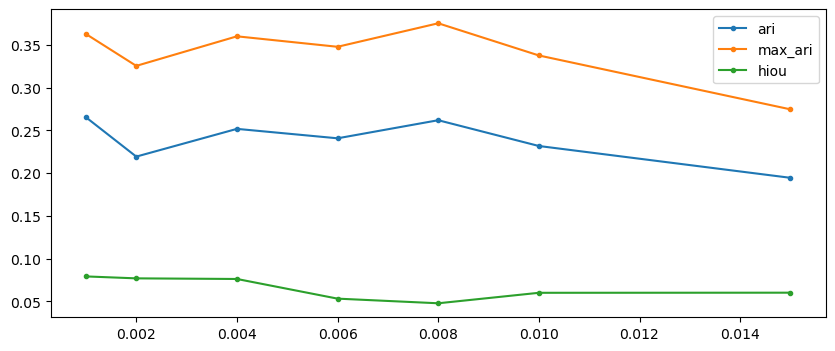

In [37]:
plt.figure(figsize=(10,4))
input_scale = np.array(table["input_scale"]).astype(float)
ari = np.array(table["ari"]).astype(float)
max_ari = np.array(table["max_ari"]).astype(float)
hiou = np.array(table["hiou"]).astype(float)
plt.plot(input_scale,ari,".-",label="ari")
plt.plot(input_scale,max_ari,".-",label="max_ari")
plt.plot(input_scale,hiou,".-",label="hiou")
plt.legend()


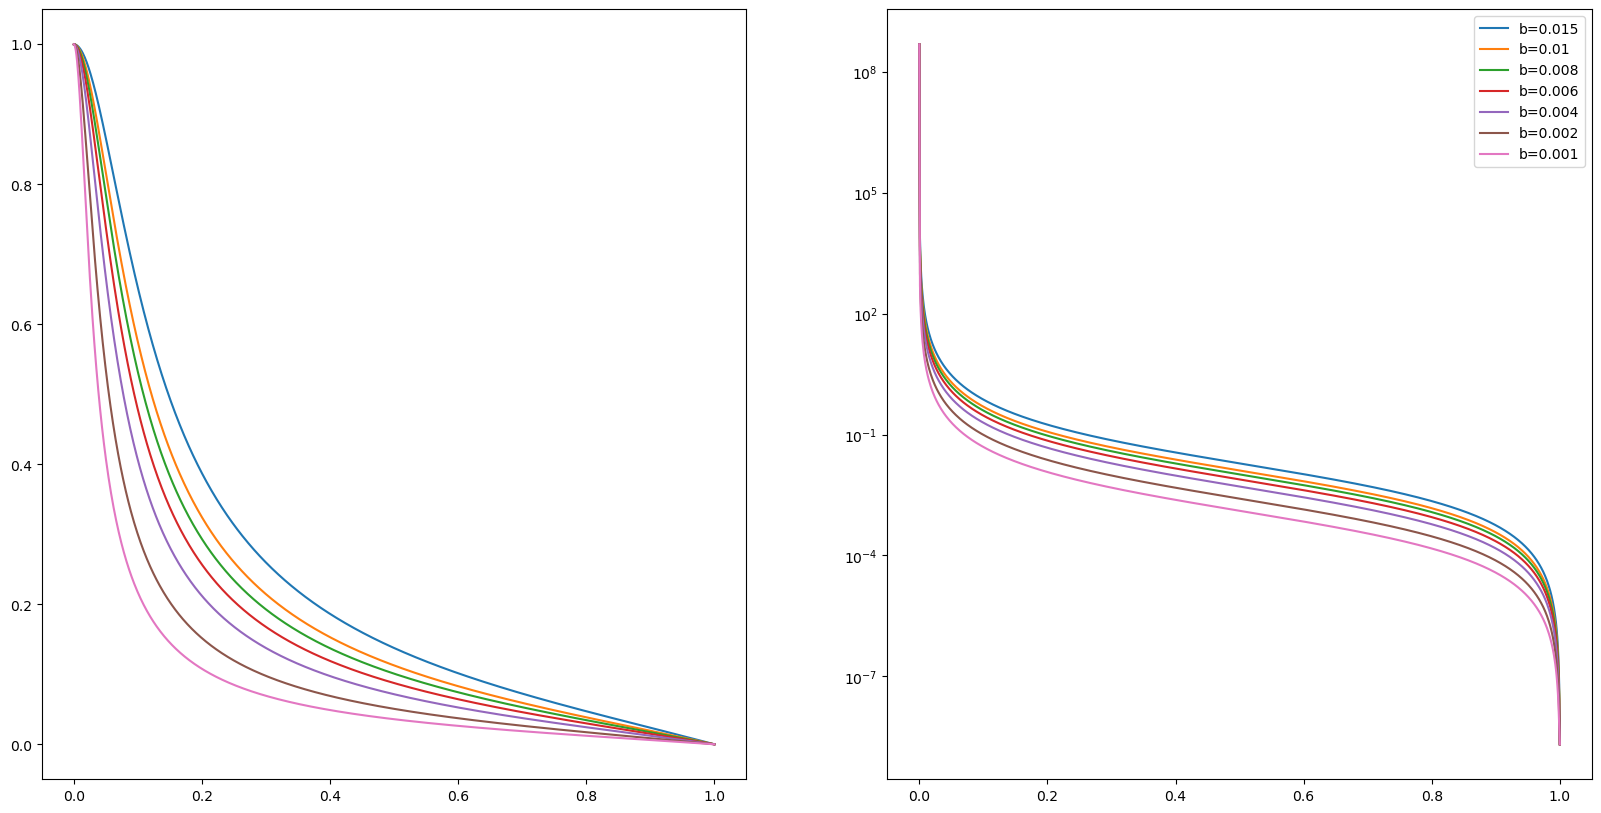

In [7]:
import torch
import numpy as np
import matplotlib.pyplot as plt
def get_named_gamma_schedule(schedule_name,b,logsnr_min=-20.0,logsnr_max=20.0):
    float64 = lambda x: torch.tensor(float(x),dtype=torch.float64)
    if schedule_name=="linear":
        gamma = lambda t: torch.sigmoid(-torch.log(torch.expm1(1e-4+10*t*t)))
    elif schedule_name.startswith("cosine"):
        num_params = len(schedule_name.split("_"))-1
        #format: cosine_start_end_tau
        tau = float64(1) if num_params<3 else float64(schedule_name.split("_")[3])
        end = float64(0) if num_params<2 else float64(schedule_name.split("_")[2])
        start = float64(1) if num_params<1 else float64(schedule_name.split("_")[1])
        def gamma(t):
            v_start = torch.cos(start * torch.pi / 2) ** (2 * tau)
            v_end = torch.cos(end * torch.pi / 2) ** (2 * tau)
            output = torch.cos((t * (end - start) + start) * torch.pi / 2) ** (2 * tau)
            output = (v_end - output) / (v_end - v_start)
            return output
        
    elif schedule_name.startswith("sigmoid"):
        num_params = len(schedule_name.split("_"))-1
        #format: cosine_start_end_tau
        sigmoid = lambda x: 1.0/(1.0+torch.exp(-x))
        tau = float64(1) if num_params<3 else float64(schedule_name.split("_")[3])
        end = float64(3) if num_params<2 else float64(schedule_name.split("_")[2])
        start = float64(-3) if num_params<1 else float64(schedule_name.split("_")[1])
        def gamma(t):
            v_start = sigmoid(start / tau)
            v_end = sigmoid(end / tau)
            output = sigmoid((t * (end - start) + start) / tau)
            output = (v_end - output) / (v_end - v_start)
            return output
    elif schedule_name=="linear_simple":
        gamma = lambda t: 1-t
    elif schedule_name=="parabola":
        #gamma = lambda t: (1-t**2)**2 expanded:
        gamma = lambda t: 1-2*t**2+t**4
    else:
        raise ValueError(f"Unknown schedule name: {schedule_name}, must be one of ['linear', 'cosine_[start]_[end]_[tau]', 'sigmoid_[start]_[end]_[tau]', 'linear_simple']")
    
    b = (b if torch.is_tensor(b) else torch.tensor(b)).to(torch.float64)
    gamma_wrap1 = input_scaling_wrap(gamma,b)
    slope,bias = logsnr_wrap(gamma_wrap1,logsnr_min,logsnr_max)
    gamma_wrap2 = lambda t: gamma_wrap1((t if torch.is_tensor(t) else torch.tensor(t)).to(torch.float64))*slope+bias
    return gamma_wrap2
def input_scaling_wrap(gamma,b=1.0):
    input_scaling = (b-1.0).abs().item()>1e-9
    if input_scaling:
        gamma_input_scaled = lambda t: b*gamma(t)/((b-1)*gamma(t)+1)
    else:
        gamma_input_scaled = gamma
    return gamma_input_scaled

def logsnr_wrap(gamma,logsnr_min=-10,logsnr_max=10,dtype=torch.float64):
    if dtype==torch.float64:
        assert logsnr_max<=36, "numerical issues are reached with logsnr_max>36 for float64"
    assert logsnr_min<logsnr_max, "expected logsnr_min<logsnr_max"
    g1_old = gamma(torch.tensor(1,dtype=dtype))
    g0_old = gamma(torch.tensor(0,dtype=dtype))
    g0_new = 1/(1+torch.exp(-torch.tensor(logsnr_max,dtype=dtype)))
    g1_new = 1/(1+torch.exp(-torch.tensor(logsnr_min,dtype=dtype)))
    slope = (g0_new-g1_new)/(g0_old-g1_old)
    bias = g1_new-g1_old*slope
    return slope,bias

schedule_name = "parabola"
input_scales = [0.015,0.01,0.008,0.006,0.004,0.002,0.001]
schedule_funcs = []
for b in input_scales:
    schedule_func = get_named_gamma_schedule(schedule_name,b,logsnr_min=-20,logsnr_max=20)
    schedule_funcs.append(schedule_func)

plt.figure(figsize=(20,10))
t = np.linspace(0,1,1000)
for b,f in zip(input_scales,schedule_funcs):
    plt.subplot(1,2,1)
    plt.plot(t,f(t)**0.5,label=f"b={b}")
    snr = f(t)/(1-f(t))
    plt.subplot(1,2,2)
    plt.plot(t,snr,label=f"b={b}")
plt.yscale("log")
plt.legend()



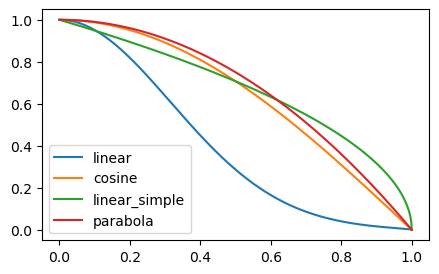

In [15]:
plt.figure(figsize=(5,3))
for s in ["linear","cosine","linear_simple","parabola"]:
    y = get_named_gamma_schedule(s,1)(t).sqrt()
    plt.plot(t,y, label=s)
plt.legend()

In [21]:
f

<function __main__.get_named_gamma_schedule.<locals>.<lambda>(t)>

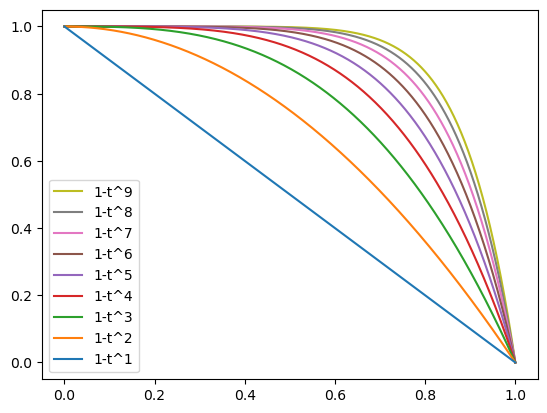

In [32]:
k_vec = np.arange(1,10)[::-1]
f = lambda t,k: 1-t**k
for k in k_vec:
    y = f(t,k)
    plt.plot(t,y,label=f"1-t^{k:d}",color=f"C{k-1}")
plt.legend()

In [42]:
x

array([[[[6, 0, 1, 5, 2, 2, 6, 7, 2, 0],
         [4, 7, 6, 4, 0, 1, 4, 4, 5, 6],
         [5, 5, 7, 6, 5, 1, 0, 7, 7, 3],
         [4, 4, 5, 3, 3, 1, 7, 5, 4, 1],
         [2, 7, 6, 0, 7, 0, 5, 3, 6, 7],
         [2, 1, 0, 6, 1, 0, 1, 7, 5, 2],
         [0, 6, 7, 6, 4, 6, 2, 5, 4, 3],
         [4, 6, 3, 0, 5, 7, 3, 3, 7, 2],
         [0, 3, 2, 3, 7, 0, 4, 1, 0, 5],
         [7, 0, 6, 2, 2, 7, 0, 7, 4, 5]]]])

In [53]:
bit_dim = 1
num_bits = 3
x = np.random.randint(0,8,(2,1,10,10))
new_shape = list(x.shape)
new_shape[bit_dim] = 2**num_bits
x_new = np.zeros(new_shape)
x_idx = 
x_new[x_idx] = 1
x = x_new


IndexError: index 5 is out of bounds for axis 0 with size 2

In [82]:
def expand_dimension_to_onehot(A,dim=1):
    assert A.shape[1]==1
    max_val = A.max()
    A_new = np.zeros([A.size,max_val+1])
    A_new[np.arange(A.size),A.flatten()] = 1
    A_new = A_new.reshape(list(A.shape)+[max_val+1])
    transpose_list = list(range(len(A_new.shape)))
    transpose_list[-1],transpose_list[dim] = dim,-1
    A_new = A_new.transpose(transpose_list).squeeze(-1)
    return A_new
x = np.random.randint(0,4,(2,1,3,3))
y = expand_dimension_to_onehot(x)
print(y.shape)

[[[[[0. 1. 0. 0.]
    [0. 0. 1. 0.]
    [0. 1. 0. 0.]]

   [[1. 0. 0. 0.]
    [0. 0. 0. 1.]
    [0. 0. 1. 0.]]

   [[0. 0. 1. 0.]
    [0. 0. 0. 1.]
    [1. 0. 0. 0.]]]]



 [[[[0. 0. 0. 1.]
    [0. 0. 0. 1.]
    [0. 1. 0. 0.]]

   [[0. 0. 0. 1.]
    [0. 0. 1. 0.]
    [0. 1. 0. 0.]]

   [[0. 0. 0. 1.]
    [1. 0. 0. 0.]
    [0. 0. 1. 0.]]]]]
(2, 1, 3, 3, 4)
(2, 4, 3, 3)


In [94]:
y.argmax(1,keepdims=True)-x

array([[[[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]]],


       [[[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]]]])

In [95]:
np.abs(x-y.argmax(1,keepdims=True)).sum()

0

In [80]:
expand_dimension_to_onehot(x).argmax(1)
x

[[[[[1. 0. 0. 0.]
    [0. 1. 0. 0.]
    [0. 1. 0. 0.]]

   [[0. 1. 0. 0.]
    [0. 0. 1. 0.]
    [0. 0. 0. 1.]]

   [[1. 0. 0. 0.]
    [0. 1. 0. 0.]
    [0. 1. 0. 0.]]]]



 [[[[0. 0. 0. 1.]
    [1. 0. 0. 0.]
    [0. 0. 0. 1.]]

   [[0. 0. 0. 1.]
    [0. 1. 0. 0.]
    [0. 0. 0. 1.]]

   [[0. 1. 0. 0.]
    [0. 0. 0. 1.]
    [1. 0. 0. 0.]]]]]
(2, 1, 3, 3, 4)


array([[[[0, 1, 1],
         [1, 2, 3],
         [0, 1, 1]]],


       [[[3, 0, 3],
         [3, 1, 3],
         [1, 3, 0]]]])

In [ ]:
python sample.py --name_match_str "*sam*" --gen_setup big_eval
python sample.py --name_match_str "*sam*" --gen_setup big_eval_ema
f

In [25]:
#time it 
import numpy as np
label = np.random.randint(0,256,(1024,1024))

def count_bins(label):
    return np.bincount(label.flatten())
reps = 500
import timeit

print(timeit.timeit(lambda: count_bins(label), number=reps)/reps)



0.001037746159825474


In [65]:
x

array([[[[5, 1, 0, 4, 2, 6, 1, 5, 6, 4],
         [5, 7, 4, 1, 0, 0, 3, 6, 3, 5],
         [2, 5, 5, 4, 1, 0, 2, 3, 2, 6],
         [4, 1, 6, 6, 1, 7, 0, 4, 4, 2],
         [6, 2, 4, 1, 4, 5, 7, 5, 5, 4],
         [4, 1, 3, 3, 5, 2, 7, 0, 4, 1],
         [6, 1, 0, 6, 2, 4, 5, 3, 3, 0],
         [6, 2, 1, 0, 3, 1, 0, 2, 7, 6],
         [7, 1, 0, 4, 1, 2, 6, 0, 0, 1],
         [0, 6, 2, 1, 1, 0, 0, 4, 6, 5]]],


       [[[0, 6, 5, 2, 7, 1, 7, 6, 2, 5],
         [4, 1, 3, 5, 6, 4, 6, 3, 3, 1],
         [1, 2, 5, 7, 7, 1, 3, 6, 6, 4],
         [4, 5, 2, 1, 1, 6, 3, 0, 5, 0],
         [1, 7, 2, 2, 2, 4, 1, 7, 3, 1],
         [6, 2, 0, 3, 5, 6, 7, 7, 4, 1],
         [0, 0, 6, 3, 3, 1, 6, 3, 6, 4],
         [6, 1, 0, 3, 1, 0, 2, 0, 5, 0],
         [0, 7, 6, 7, 0, 1, 1, 1, 2, 3],
         [4, 4, 7, 1, 5, 4, 3, 0, 2, 2]]]])

In [ ]:
zip -r monu4.zip ./monu4
zip -r monu.zip ./monu

In [ ]:
python data/download_datasets.py --process 5
python data/download_datasets.py --process 3
f

In [ ]:
python train.py --model_name nc_big --mode cont
python train.py --model_name nc2[tanh]
python train.py --model_name nc2[lr]
python train.py --model_name nc2[tanh] --mode cont
python train.py --model_name nc2[lr] --mode cont
f


In [9]:


sam_image_encoder,input_size,output_size = get_sam_image_encoder(model_type="vit_b",device="cuda")

In [14]:
import torch
sam_image_encoder(torch.zeros(input_size).cuda().unsqueeze(0)).shape

torch.Size([1, 256, 64, 64])

In [4]:
import jlc
jlc.num_of_params(sam_image_encoder)

The model has:
89670912 trainable parameters
0 untrainable parameters
89670912 total parameters


(89670912, 0, 89670912)

In [10]:
input_size,output_size


((3, 1024, 1024), (256, 64, 64))

In [17]:
(0.4107+0.0755+0.0456+0.9282)/4

0.365

In [16]:
import torch.nn.functional as F
a = torch.rand(1,3,4,4)
b = F.avg_pool2d(a,2)
print(a)
print(b)

tensor([[[[0.4107, 0.0755, 0.9874, 0.9053],
          [0.0456, 0.9282, 0.0072, 0.3655],
          [0.2905, 0.8964, 0.5089, 0.3986],
          [0.3340, 0.0270, 0.2105, 0.7569]],

         [[0.9814, 0.5599, 0.2049, 0.2117],
          [0.2994, 0.1873, 0.2104, 0.9831],
          [0.2015, 0.2971, 0.0061, 0.0262],
          [0.4619, 0.7158, 0.5662, 0.8292]],

         [[0.7160, 0.8119, 0.0427, 0.6153],
          [0.2875, 0.6597, 0.8470, 0.2999],
          [0.3171, 0.5592, 0.1397, 0.7210],
          [0.0810, 0.8537, 0.7324, 0.4470]]]])
tensor([[[[0.3650, 0.5664],
          [0.3870, 0.4687]],

         [[0.5070, 0.4025],
          [0.4191, 0.3569]],

         [[0.6188, 0.4512],
          [0.4527, 0.5100]]]])


In [ ]:
python train.py --model_name sam[128] --mode cont
python train.py --model_name sam[128] --mode cont
python train.py --model_name sam
python train.py --model_name sam --mode cont
python train.py --model_name nc2[lr]
python train.py --model_name nc2[lr] --mode cont
python train.py --model_name nc_big --mode cont
f

In [33]:
%load_ext autoreload
%autoreload 2
import os,sys
sys.path.append('./source/')

from argparse_utils import TieredParser

In [37]:
tp = TieredParser()
print(tp.defaults_func())

k=datasets, v=non-medical,, v_hat=non-medical, t=<function list_wrap_type.<locals>.list_wrap at 0x7faa3c866f70>
{'model_name': 'default', 'model_version': '1.0.0', 'model_id': '[model_name]_*', 'save_path': '', 'seed': -1, 'step_time': '', 'origin': '', 'no_diffusion': False, 'noise_schedule': 'cosine', 'sigma_small': False, 'schedule_sampler': 'uniform_low_d', 'input_scale': 0.01, 'logsnr_min': -20.0, 'logsnr_max': 20.0, 'use_checkpoint': False, 'channel_multiplier': 'auto', 'dropout': 0.0, 'predict': 'x', 'use_scale_shift_norm': False, 'num_res_blocks': 3, 'num_heads': 4, 'num_heads_upsample': -1, 'num_channels': 64, 'attention_resolutions': '-2,-1', 'image_size': 64, 'deeper_net': False, 'weak_signals': False, 'class_type': 'none', 'self_cond': False, 'max_num_classes': 8, 'cond_type': 'none', 'time_cond_type': 't', 'onehot': False, 'final_activation': 'none', 'image_encoder': 'none', 'image_encoder_depth': 0, 'gen_interval': 1000, 'gen_setups': 'vali,train', 'remove_old_plots': Tru

In [38]:
tp.defaults_func()["datasets"]

'non-medical,'

In [45]:
def longest_common_substring(str1, str2):
    dp = [[0] * (len(str2) + 1) for _ in range(len(str1) + 1)]
    max_length = 0
    end_position = 0
    for i in range(1, len(str1) + 1):
        for j in range(1, len(str2) + 1):
            if str1[i - 1] == str2[j - 1]:
                dp[i][j] = dp[i - 1][j - 1] + 1
                if dp[i][j] > max_length:
                    max_length = dp[i][j]
                    end_position = i
            else:
                dp[i][j] = 0
    return max_length
# Example usage:
str1 = "abcdef"
str2 = "1abc"
result = longest_common_substring(str1, str2)
print("Longest Common Substring:", result)


Longest Common Substring: 3


In [88]:
%load_ext autoreload
%autoreload 2
import os,sys
sys.path.append('./source/')
sys.path.append('./data/')
from argparse_utils import TieredParser
import numpy as np
from data.download_datasets import process_bg, prettify_data
import matplotlib.pyplot as plt
from source.plot_utils import analog_bits_on_image,mask_overlay_smooth
import jlc
from PIL import Image
from pathlib import Path
from source.datasets import SegmentationDataset
import scipy.ndimage as nd
import tqdm
dataset = SegmentationDataset(crop_method="sam_big",
                              shuffle_nonzero_labels=False,
                      shuffle_zero=False,)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
processing dataset:  coco
processing dataset:  pascal
processing dataset:  sa1b
processing dataset:  coift
processing dataset:  hrsod
processing dataset:  to5k
processing dataset:  ade20k
processing dataset:  dram
processing dataset:  cityscapes


mask.min: 1 mask.max: 6
mask.min: 1 mask.max: 255


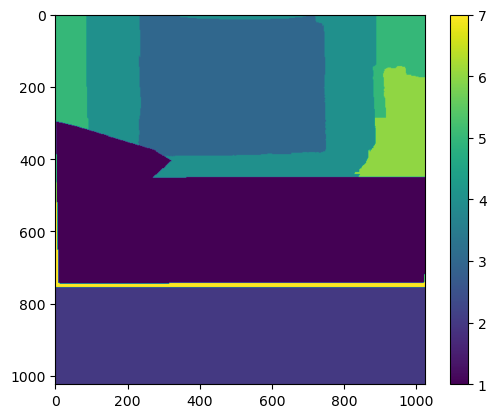

In [89]:
x,info = dataset[0]
plt.imshow(x.permute(1,2,0))
plt.colorbar()

In [ ]:
python train.py --model_name sam[128] --lr 0.00003
python train.py --model_name sam[128] --mode cont
python train.py --model_name sam
python train.py --model_name sam --mode cont
python train.py --model_name sam[128]
f

In [94]:
import datetime


'24-02-20-10-28'

In [97]:
from pathlib import Path
opts = {"gen_setup": "vali-ts10",
        "gen_version": "1.0.0",
        "gen_id": "vali-ts10_0",
        "name_match_str": "saves/2024-02-19-17-16-55-965746_sam[128]/ckpt_050000.pt",
        "seed": -1,
        "grid_filename": "saves/2024-02-19-17-16-55-965746_sam[128]/samples/grid_vali-ts10_0_050000.png",
        "inter_folder": "saves/2024-02-19-17-16-55-965746_sam[128]/samples/inter_vali-ts10_0_050000",
        "raw_samples_folder": "",
        "concat_inter_filename": "saves/2024-02-19-17-16-55-965746_sam[128]/samples/concat_vali-ts10_0_050000.png",
        "origin": {"gen_setup": "modified_args"},
        "default_save_folder": "saves/2024-02-19-17-16-55-965746_sam[128]/samples"}
s_opt_keys = "grid_filename,concat_inter_filename,raw_samples_folder,inter_folder".split(",")
#kill_criterion = lambda x: any([(Path(x[k]).exists() and len(x[k])>0) for k in s_opt_keys])
for k in s_opt_keys:
    print("opts[k]="+str(opts[k])+", crit="+str((Path(opts[k]).exists() and len(opts[k])>0)))  

opts[k]=saves/2024-02-19-17-16-55-965746_sam[128]/samples/grid_vali-ts10_0_050000.png, crit=True
opts[k]=saves/2024-02-19-17-16-55-965746_sam[128]/samples/concat_vali-ts10_0_050000.png, crit=True
opts[k]=, crit=False
opts[k]=saves/2024-02-19-17-16-55-965746_sam[128]/samples/inter_vali-ts10_0_050000, crit=True


In [ ]:
python train.py --model_name "sam[ce1];sam[ce2];sam[ce3];sam[ce4]"
python train.py --model_name "sam[ce1];sam[ce2];sam[ce3];sam[ce4]" --mode cont
f

In [12]:
%load_ext autoreload
%autoreload 2
import sys, os
sys.path.append('./source/')

from source.datasets import SegmentationDataset

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
ds = SegmentationDataset(datasets="pascal")

In [ ]:
python train.py --mode cont --max_iter 100000 --ckpt_name *46_sam[128]/ckpt_*.pt --model_name sam[128]
python train.py --mode cont --max_iter 100000 --ckpt_name *46_sam[128]/ckpt_*.pt --model_name sam[128]
python train.py --model_name sam[128_slow]
python train.py --model_name sam[128_slow] --mode cont
python train.py --model_name sam[tanh]
python train.py --model_name sam[tanh] --mode cont
python train.py --model_name sam[256]
python train.py --model_name sam[256] --mode cont
f

In [67]:
a = np.random.randint(0,256,(10,))
b = np.random.randint(0,10,(0,))
print(a[b])

[]


In [81]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import os,sys
sys.path.append('./source/')
sys.path.append('./data/')
from source.datasets import SegmentationDataset
dataset = SegmentationDataset(split_method="native_train")
print(len(dataset))


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
processing dataset:  coco
n_to_a: 
 [[98629  7329 12329]
 [    0  5000     0]
 [    0     0     0]]
native:  [118287, 5000, 0]
target:  [98629, 12329, 12329]
actual:  [98629 12329 12329]
processing dataset:  pascal
n_to_a: 
 [[8082 1010 1011]
 [   0    0    0]
 [   0    0    0]]
native:  [10103, 0, 0]
target:  [8082, 1010, 1011]
actual:  [8082 1010 1011]
processing dataset:  sa1b
n_to_a: 
 [[8682 1085 1086]
 [   0    0    0]
 [   0    0    0]]
native:  [10853, 0, 0]
target:  [8682, 1085, 1086]
actual:  [8682 1085 1086]
processing dataset:  coift
n_to_a: 
 [[224  28  28]
 [  0   0   0]
 [  0   0   0]]
native:  [280, 0, 0]
target:  [224, 28, 28]
actual:  [224  28  28]
processing dataset:  hrsod
n_to_a: 
 [[226  28  29]
 [  0   0   0]
 [  0   0   0]]
native:  [283, 0, 0]
target:  [226, 28, 29]
actual:  [226  28  29]
processing dataset:  to5k
n_to_a: 
 [[4598  575  575]
 [   0    0    0]
 [   0    0    

In [ ]:
python train.py --model_name sam[64_native_tanh]
python train.py --model_name sam[64_native_tanh] --mode cont
python train.py --model_name sam[128_native_tanh]
python train.py --model_name sam[128_native_tanh] --mode cont
f

In [ ]:
python train.py --model_name sam[128_native_tanh] --mode cont --ckpt_name *sam[128_native_tanh]_0/ckpt_*.pt
python train.py --model_name sam[256_native_tanh]
python train.py --model_name sam[256_native_tanh] --mode cont
python train.py --model_name sam[256_native_tanh] --mode cont
f

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [52]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import os,sys
sys.path.append('./source/')
sys.path.append('./data/')
import numpy as np
from PIL import Image
from pathlib import Path
from argparse_utils import TieredParser
from source.datasets import SegmentationDataset, custom_collate_with_info
import jlc
import torch
args = TieredParser().get_args(alt_parse_args=[])
split = "vali"
dataset = SegmentationDataset(split=split,
                            image_size=args.image_size,
                            datasets=args.datasets,
                            min_label_size=args.min_label_size,
                            max_num_classes=args.max_num_classes,
                            shuffle_zero=args.shuffle_zero,
                            geo_aug_p=args.geo_aug_prob,
                            crop_method=args.crop_method,
                            label_padding_val=255 if args.ignore_padded else 0,
                            split_method=args.split_method)
bs = {"train": args.train_batch_size,
        "vali": args.vali_batch_size if args.vali_batch_size>0 else args.train_batch_size,
        "test": args.train_batch_size}[split]
dataloader = jlc.DataloaderIterator(torch.utils.data.DataLoader(dataset,
                            batch_size=bs,
                            sampler=dataset.get_sampler(123) if hasattr(dataset,"get_sampler") else None,
                            shuffle=not hasattr(dataset,"get_sampler"),
                            drop_last=True,
                            collate_fn=custom_collate_with_info,
                            num_workers=args.dl_num_workers))

processing dataset:  coco
processing dataset:  pascal
processing dataset:  sa1b
processing dataset:  coift
processing dataset:  hrsod
processing dataset:  to5k
processing dataset:  ade20k
processing dataset:  dram
processing dataset:  cityscapes


In [53]:
batch = next(dataloader)
print([b["dataset_name"]+"/"+str(b["i"]) for b in batch[-1]])

['pascal/4430', 'coco/74014', 'hrsod/184', 'coco/82615', 'sa1b/4156', 'sa1b/2164', 'to5k/3378', 'sa1b/7619']


In [47]:
batch = next(dataloader)
print([b["dataset_name"]+"/"+str(b["i"]) for b in batch[-1]])

['cityscapes/1238', 'coco/46539', 'ade20k/17065', 'coco/86860', 'pascal/3883', 'pascal/1018', 'pascal/673', 'sa1b/7356']


In [49]:
batch = next(dataloader)
print([b["dataset_name"]+"/"+str(b["i"]) for b in batch[-1]])

['pascal/4430', 'coco/74014', 'hrsod/184', 'coco/82615', 'sa1b/4156', 'sa1b/2164', 'to5k/3378', 'sa1b/7619']


In [50]:
a = np.random.randint(0,256,(10,10))
b = torch.rand(10,10)

In [51]:
batch = next(dataloader)
print([b["dataset_name"]+"/"+str(b["i"]) for b in batch[-1]])

['cityscapes/1238', 'coco/46539', 'ade20k/17065', 'coco/86860', 'pascal/3883', 'pascal/1018', 'pascal/673', 'sa1b/7356']


In [54]:
from utils import TemporarilyDeterministic

with TemporarilyDeterministic(123):
    batch = next(dataloader)
    print([b["dataset_name"]+"/"+str(b["i"]) for b in batch[-1]])

['cityscapes/1238', 'coco/46539', 'ade20k/17065', 'coco/86860', 'pascal/3883', 'pascal/1018', 'pascal/673', 'sa1b/7356']


In [2]:
import logging
import atexit
import os
#create log.txt

with open('log.txt', 'w') as fp:
    pass

In [4]:


# Configure the logging module
logging.basicConfig(filename='log.txt', level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# Your existing log method
def log(msg):
    logging.info(msg)

# Function to be executed at exit
def log_errors_on_exit():
    if hasattr(logging, '_show_warnings'):  # Check if logging has been configured
        logging.shutdown()  # Shut down the logging system to ensure all logs are flushed

    # Check if there are any unhandled exceptions
    if hasattr(sys, 'last_type') and hasattr(sys, 'last_value'):
        logging.error(f"Unhandled exception: {sys.last_type}: {sys.last_value}")
        traceback.print_exception(sys.last_type, sys.last_value, sys.last_traceback)

# Register the function to be executed at exit
atexit.register(log_errors_on_exit)

# Your large code block
def your_massive_code_block():
    # Your code logic here
    # ...

    # Log regular messages
    log("This is a regular log message")
    raise ValueError("This is an unhandled exception")
# Call your code logic
your_massive_code_block()


ValueError: This is an unhandled exception

In [ ]:
python sample.py --name_match_str "*sam[64_native_tanh]*" --gen_setup all_ade20k
python sample.py --name_match_str "*sam[128_native_tanh]*" --gen_setup all_ade20k
python sample.py --name_match_str "*sam[256_native_tanh]*" --gen_setup all_ade20k
f

In [ ]:
git remote set-url origin git@github.com:JakobLC/diffusion2.git

In [ ]:
python train.py --model_name "sam[64_nc_slow]"
python train.py --model_name "sam[64_nc_slow]" --mode cont
python train.py --model_name "sam[128_nc_slow]"
python train.py --model_name "sam[128_nc_slow]" --mode cont
f


In [ ]:
python train.py --model_name "weak[64];weak[128];logits[contweak];logits;logits[sam];logits[lr1]"
python train.py --model_name "weak[64];weak[128];logits[contweak];logits;logits[sam];logits[lr1]" --mode cont
f


/tmp/ipykernel_715086/2185887936.py:2: RuntimeWarning: divide by zero encountered in log
  y = -t*np.log(t)
/tmp/ipykernel_715086/2185887936.py:2: RuntimeWarning: invalid value encountered in multiply
  y = -t*np.log(t)


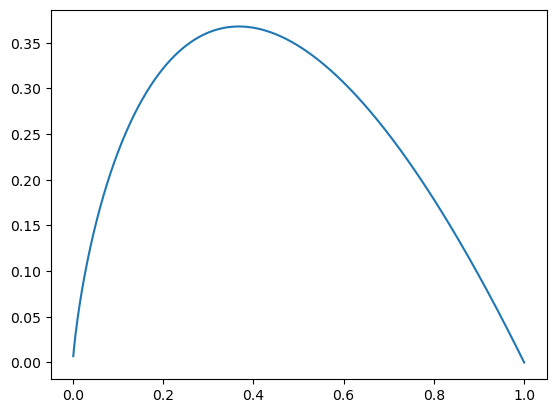

In [30]:

t = np.linspace(0,1,1000)
y = -t*np.log(t)
plt.plot(t,y)

In [49]:
import torch
%load_ext autoreload
%autoreload 2
import os,sys
sys.path.append('./source/')
from sam_and_eval import evaluate_sam, SavedSamples, SavedSamplesManager, DiffSamples
import matplotlib.pyplot as plt
from utils import shaprint
import argparse
import numpy as np
from cont_gaussian_diffusion import AnalogBits
def entropy_score_from_predx(predx,mean_reduce=True):
    num_bits = predx.shape[1]
    entropy = entropy_from_predx(predx,mean_reduce=False,as_onehot=False).sum(1)
    coef = 1/np.log(2**num_bits)
    entropy_score = 1-entropy*coef
    if mean_reduce:
        entropy_score = torch.mean(entropy_score)
    return entropy_score

def entropy_from_predx(predx,mean_reduce=True,as_onehot=False):
    num_bits = predx.shape[1]
    if as_onehot:
        probs = AnalogBits(num_bits=num_bits).bit2prob(predx)
    else:
        probs = predx.unsqueeze(1)*0.5+0.5
        #each number is a probability, so we must add the complementary probability
        probs = torch.cat([probs,1-probs],axis=1)
    entropy = -torch.sum(probs*torch.log(probs+1e-9),dim=1)
    if mean_reduce:
        entropy = torch.mean(entropy)
    return entropy

n = 10
classes = 3
a = torch.rand(n,classes)*2-1
b = entropy_from_predx(a,False,as_onehot=False)
c = entropy_from_predx(a,False,as_onehot=True)
d = entropy_score_from_predx(a)

print(b.shape,c.shape)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
torch.Size([10, 3]) torch.Size([10])


In [52]:
(1-c/np.log(2**classes)).mean()

tensor(0.3320, dtype=torch.float64)

In [50]:
d

tensor(0.3320)

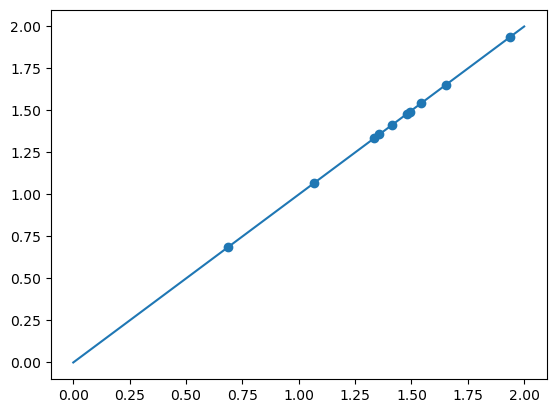

In [46]:
plt.scatter(b.sum(1),c)
plt.plot([0,2],[0,2])


In [33]:
b.shape, c.shape

(torch.Size([10, 3]), torch.Size([10]))

In [4]:
%load_ext autoreload
%autoreload 2
#%matplotlib qt5
import os,sys
sys.path.append('./source/')
from sam_and_eval import evaluate_sam, SavedSamples, DiffSamples, extract_from_samples, plot_qual_seg, didx_from_info, SavedSamplesManager
import matplotlib.pyplot as plt
from utils import shaprint, save_dict_list_to_json
import numpy as np
from pprint import pprint
from pathlib import Path
import jlc
import nibabel as nib
from plot_utils import mask_overlay_smooth
from utils import quantile_normalize
import tqdm
folder = "./data/totseg/Totalsegmentator_dataset_v201/"



def load_totseg(f,class_to_idx=None):
    #loads a volume and its segmentation
    vol = nib.load(f).get_fdata()
    if class_to_idx is None:
        assert os.path.exists(f.replace("ct.nii.gz","seg.nii.gz")), f"Missing segmentation for {f}"
        seg = nib.load(f.replace("ct.nii.gz","seg.nii.gz")).get_fdata().astype(np.uint8)
    else:
        seg_files = Path(f).parent.glob("segmentations/*.nii.gz")
        seg = np.zeros(vol.shape,dtype=np.uint8)
        for s in seg_files:
            class_name = Path(s).name.replace(".nii.gz","")
            mask = nib.load(s).get_fdata()>0
            seg[mask] = class_to_idx[class_name]
    return vol, seg

def totseg_vol_to_slices(f,delta=10):
    vol, seg = load_totseg(f)
    vol = quantile_normalize(vol)
    s = vol.shape
    slice_idx = [list(range(0,s[dim_i],delta)) for dim_i in range(3)]
    slices = []
    slice_segs = []
    for dim_i in range(3):
        idx = [slice(None) for _ in range(3)]
        slices.append([])
        slice_segs.append([])
        for i in slice_idx[dim_i]:
            idx[dim_i] = i
            slices[-1].append(vol[tuple(idx)])
            slice_segs[-1].append(seg[tuple(idx)])
    return slices, slice_segs

def create_totseg_label(f,class_to_idx=None):
    #saves a segmentation as a combined file in the same folder as the volume 
    f2 = f.replace("ct.nii.gz","seg.nii.gz")
    vol, seg = load_totseg(f,class_to_idx)
    nib.save(nib.Nifti1Image(seg, np.eye(4)), f2)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
all_segmentations = Path(folder).glob("*/segmentations/*.nii.gz")
all_segmentations = [str(f) for f in all_segmentations]
print("#segmentations", len(list(all_segmentations)))
classes = [Path(f).name.replace(".nii.gz","") for f in all_segmentations]
print(classes[:5])
uq_classes = list(set(classes))
uq_classes = sorted(uq_classes)
print("#unique classes", len(uq_classes))
idx_to_class = {0: "background"}
for i, c in enumerate(uq_classes):
    idx_to_class[i+1] = c
class_to_idx = {v:k for k,v in idx_to_class.items()}
class_dict_path = "/home/jloch/Desktop/diff/diffusion2/data/totseg/Totalsegmentator_dataset_v201/idx_to_class_alphabetical.json"
save_dict_list_to_json(idx_to_class,class_dict_path)

#segmentations 143676
['rib_left_10', 'vertebrae_T2', 'vertebrae_L5', 'urinary_bladder', 'vertebrae_T6']
#unique classes 117


In [5]:
#ONETIME: create all segmentation volumes
filenames = Path(folder).glob("*/ct.nii.gz")
filenames = [str(f) for f in filenames]
filenames = sorted(filenames)
print("#files", len(list(filenames)))
print("first 3 files")
pprint(filenames[:3])

for f in tqdm.tqdm(filenames):
    create_totseg_label(f,class_to_idx)

#files 1228
first 3 files
['data/totseg/Totalsegmentator_dataset_v201/s0000/ct.nii.gz',
 'data/totseg/Totalsegmentator_dataset_v201/s0001/ct.nii.gz',
 'data/totseg/Totalsegmentator_dataset_v201/s0002/ct.nii.gz']


  0%|          | 0/1228 [00:00<?, ?it/s]

100%|██████████| 1228/1228 [1:34:35<00:00,  4.62s/it] 


In [6]:
vol,seg = load_totseg(filenames[0])
print(filenames[0])
uq_idx = np.unique(seg.flatten())
uq_names = [idx_to_class[i] for i in uq_idx]
pprint([f"{a}: {b}" for a,b in zip(uq_idx,uq_names)])

data/totseg/Totalsegmentator_dataset_v201/s0000/ct.nii.gz
['0: background',
 '13: colon',
 '19: femur_left',
 '20: femur_right',
 '22: gluteus_maximus_left',
 '23: gluteus_maximus_right',
 '24: gluteus_medius_left',
 '25: gluteus_medius_right',
 '26: gluteus_minimus_left',
 '27: gluteus_minimus_right',
 '29: hip_left',
 '30: hip_right',
 '33: iliac_artery_left',
 '34: iliac_artery_right',
 '35: iliac_vena_left',
 '36: iliac_vena_right',
 '37: iliopsoas_left',
 '38: iliopsoas_right',
 '69: rib_right_12',
 '78: sacrum',
 '82: small_bowel',
 '92: urinary_bladder']


In [23]:
segs = [str(f) for f in (Path(filenames[0]).parent/"segmentations").glob("*.nii.gz")]
names = []
for seg in segs:
    loaded = nib.load(seg).get_fdata()
    if loaded.max()>0:
        names.append(Path(seg).name.replace(".nii.gz",""))
print(sorted(names))

['colon', 'femur_left', 'femur_right', 'gluteus_maximus_left', 'gluteus_maximus_right', 'gluteus_medius_left', 'gluteus_medius_right', 'gluteus_minimus_left', 'gluteus_minimus_right', 'hip_left', 'hip_right', 'iliac_artery_left', 'iliac_artery_right', 'iliac_vena_left', 'iliac_vena_right', 'iliopsoas_left', 'iliopsoas_right', 'rib_right_12', 'sacrum', 'small_bowel', 'urinary_bladder']


In [10]:


%load_ext autoreload
%autoreload 2
%matplotlib inline
import os,sys
sys.path.append('./source/')
sys.path.append('./data/')
from unet import DynamicViT,get_dynamic_vit
import numpy as np
from PIL import Image
from pathlib import Path
from argparse_utils import TieredParser
from source.datasets import SegmentationDataset, custom_collate_with_info
import jlc
import torch
args = TieredParser().get_args(alt_parse_args=[])
split = "vali"
dataset = SegmentationDataset(split=split,
                            image_size=args.image_size,
                            datasets=args.datasets,
                            min_label_size=args.min_label_size,
                            max_num_classes=args.max_num_classes,
                            shuffle_zero=args.shuffle_zero,
                            geo_aug_p=args.geo_aug_prob,
                            crop_method=args.crop_method,
                            label_padding_val=255 if args.ignore_padded else 0,
                            split_method=args.split_method)
bs = {"train": args.train_batch_size,
        "vali": args.vali_batch_size if args.vali_batch_size>0 else args.train_batch_size,
        "test": args.train_batch_size}[split]
dataloader = jlc.DataloaderIterator(torch.utils.data.DataLoader(dataset,
                            batch_size=bs,
                            sampler=dataset.get_sampler(123) if hasattr(dataset,"get_sampler") else None,
                            shuffle=not hasattr(dataset,"get_sampler"),
                            drop_last=True,
                            collate_fn=custom_collate_with_info,
                            num_workers=args.dl_num_workers))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
processing dataset:  coco
processing dataset:  pascal
processing dataset:  sa1b
processing dataset:  coift
processing dataset:  hrsod
processing dataset:  to5k
processing dataset:  ade20k
processing dataset:  dram
processing dataset:  cityscapes
processing dataset:  visor
processing dataset:  duts
processing dataset:  ecssd
processing dataset:  fss
processing dataset:  msra
processing dataset:  dis


In [16]:
vit = get_dynamic_vit(-2)

In [17]:
jlc.num_of_params(vit)

The model has:
5114112 trainable parameters
0 untrainable parameters
5114112 total parameters


(5114112, 0, 5114112)

In [ ]:
dummy_input = "special_tokens"